In [2]:
!pip install scikit-image opencv-python noise2void --quiet
!pip install pywavelets

ERROR: Could not find a version that satisfies the requirement noise2void (from versions: none)
ERROR: No matching distribution found for noise2void


Median Filter:  PSNR=27.33, SSIM=0.5631, MSE=0.001851
Wavelet Denoise: PSNR=28.60, SSIM=0.7614, MSE=0.001379
Noise2Void (Mock): PSNR=29.27, SSIM=0.7385, MSE=0.001182


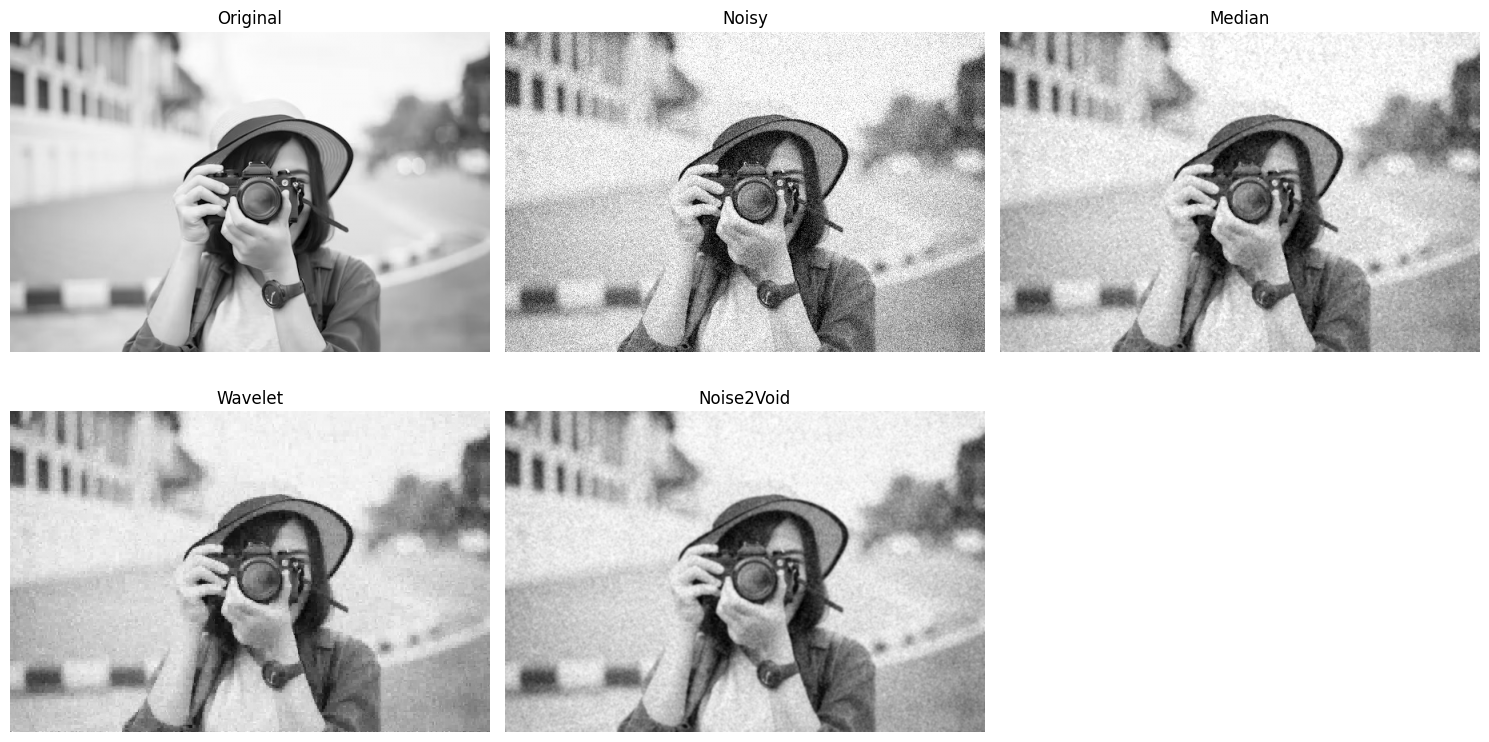

In [3]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, restoration, metrics, color
from skimage.util import random_noise
import pywt

# Load image and convert to grayscale
image = img_as_float(io.imread('/content/sample_data/premium_photo-1664474619075-644dd191935f.jpg'))  # Use your own if needed
if image.ndim == 3:
    # If image has an alpha channel (4 channels), remove it before conversion to grayscale
    if image.shape[2] == 4:
        image = image[:, :, :3]  # Select only the first 3 channels (RGB)
    image = color.rgb2gray(image)

# Add Gaussian noise
noisy_image = random_noise(image, mode='gaussian', var=0.01)

# --- 1. Median Filter Denoising ---
median_denoised = cv2.medianBlur((noisy_image * 255).astype(np.uint8), 3) / 255.0

# --- 2. Wavelet Denoising ---
# Replace 'multichannel' with 'channel_axis' and set to None for grayscale images
wavelet_denoised = restoration.denoise_wavelet(noisy_image, channel_axis=None)


# --- 3. Noise2Void (mock result, replace with model prediction if available) ---
# Here we mock Noise2Void output with Gaussian filter for demonstration (replace with actual model prediction)
from scipy.ndimage import gaussian_filter
denoised_n2v = gaussian_filter(noisy_image, sigma=1)

# --- Metric Calculation Function ---
def evaluate(original, denoised):
    psnr = metrics.peak_signal_noise_ratio(original, denoised)
    # Specify data_range for structural_similarity
    ssim = metrics.structural_similarity(original, denoised, data_range=1.0)
    mse = metrics.mean_squared_error(original, denoised)
    return psnr, ssim, mse

metrics_median = evaluate(image, median_denoised)
metrics_wavelet = evaluate(image, wavelet_denoised)
metrics_n2v = evaluate(image, denoised_n2v)

# --- Print Metrics ---
print("Median Filter:  PSNR={:.2f}, SSIM={:.4f}, MSE={:.6f}".format(*metrics_median))
print("Wavelet Denoise: PSNR={:.2f}, SSIM={:.4f}, MSE={:.6f}".format(*metrics_wavelet))
print("Noise2Void (Mock): PSNR={:.2f}, SSIM={:.4f}, MSE={:.6f}".format(*metrics_n2v))

# --- Visualization ---
titles = ['Original', 'Noisy', 'Median', 'Wavelet', 'Noise2Void']
images = [image, noisy_image, median_denoised, wavelet_denoised, denoised_n2v]


plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Upload a .mp4 video
from google.colab import files
uploaded = files.upload()  # Upload your video file here

import cv2
import os

# Create directory to store frames
video_path = next(iter(uploaded))  # Use the uploaded video filename
output_dir = "extracted_frames"
os.makedirs(output_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
    cv2.imwrite(frame_path, frame)
    frame_count += 1

cap.release()
print(f"{frame_count} frames extracted to '{output_dir}'")

Saving 3253859-uhd_3840_2160_25fps.mp4 to 3253859-uhd_3840_2160_25fps.mp4
362 frames extracted to 'extracted_frames'


In [5]:
# Create directories for each processing step
os.makedirs("processed/threshold", exist_ok=True)
os.makedirs("processed/gaussian", exist_ok=True)
os.makedirs("processed/canny", exist_ok=True)
os.makedirs("processed/invert", exist_ok=True)

# Reload frames
frame_files = sorted(os.listdir(output_dir))

for fname in frame_files:
    path = os.path.join(output_dir, fname)
    frame = cv2.imread(path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # Gaussian smoothing
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Bitwise not
    inverted = cv2.bitwise_not(gray)

    # Save processed frames
    cv2.imwrite(f"processed/threshold/{fname}", thresh)
    cv2.imwrite(f"processed/gaussian/{fname}", blur)
    cv2.imwrite(f"processed/canny/{fname}", edges)
    cv2.imwrite(f"processed/invert/{fname}", inverted)


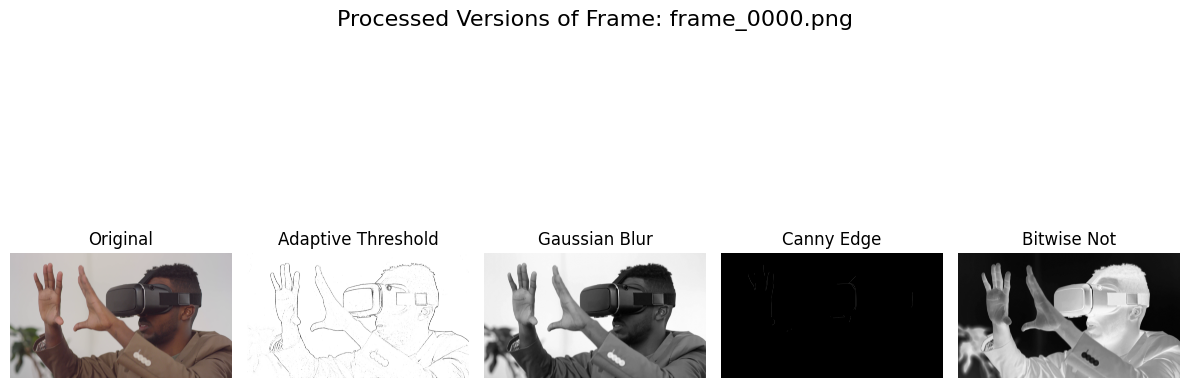

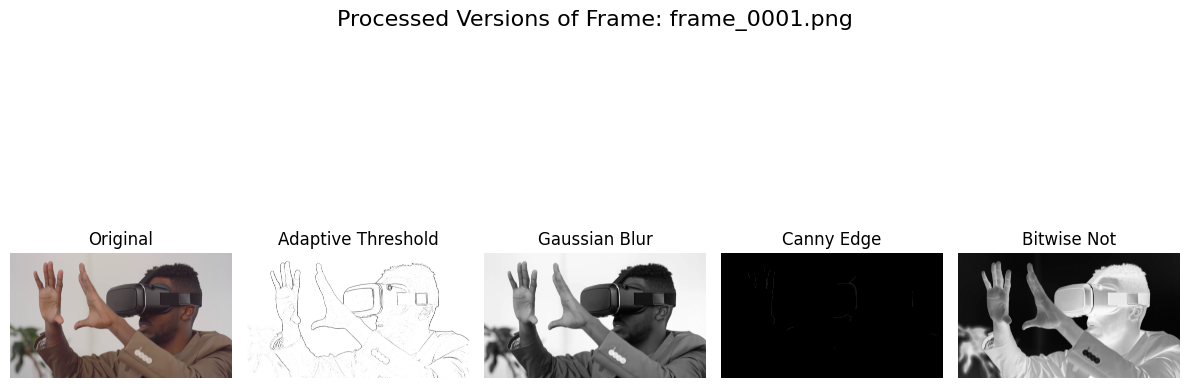

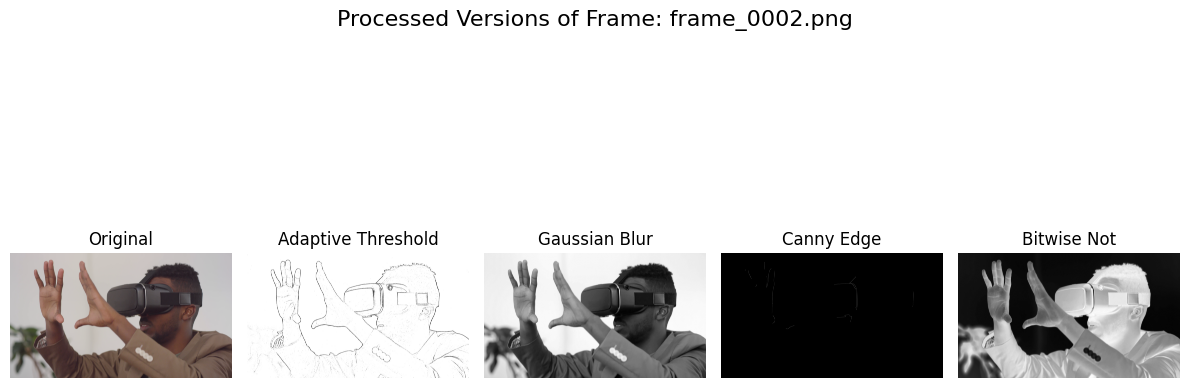

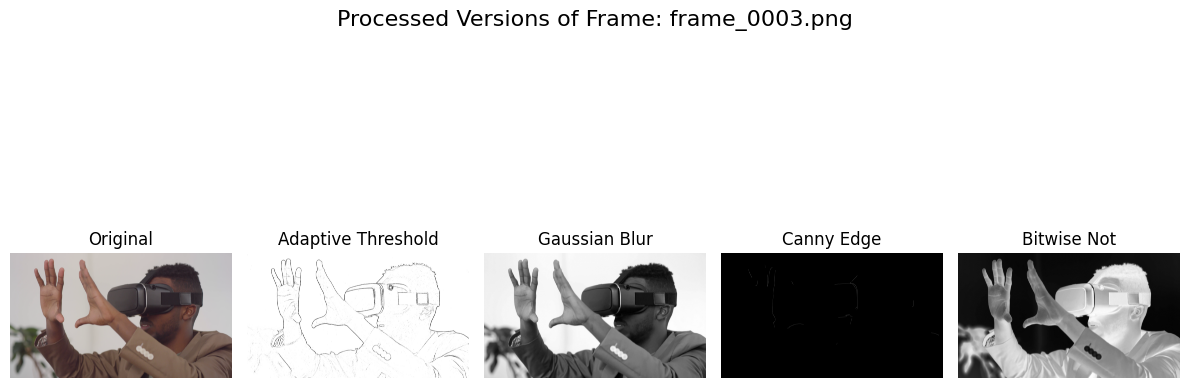

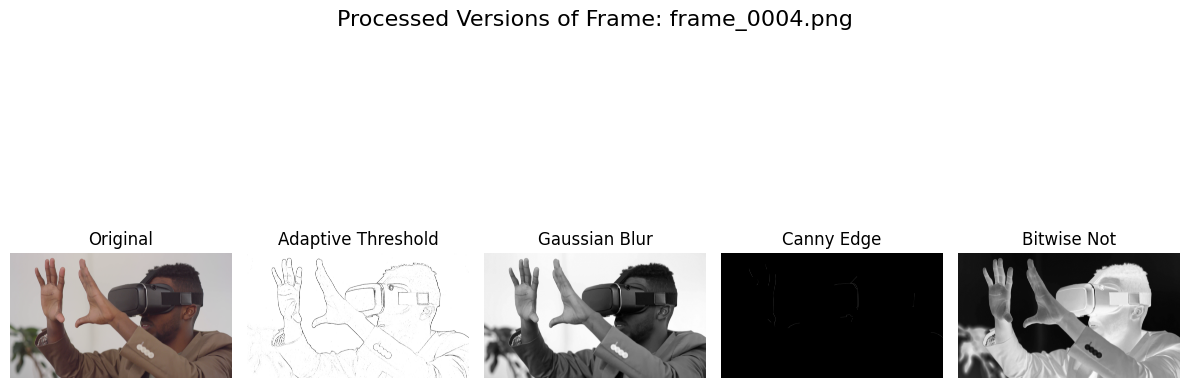

In [6]:
import matplotlib.pyplot as plt

# Select a few sample frames to display
sample_frames = frame_files[:5]  # Change this to show more

for fname in sample_frames:
    path = os.path.join(output_dir, fname)
    frame = cv2.imread(path)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply transformations
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 100, 200)
    inverted = cv2.bitwise_not(gray)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Processed Versions of Frame: {fname}", fontsize=16)

    # plt.figure(figsize=(12, 6))
    # plt.suptitle(f"Processed Versions of Frame: {fname}\nCREATED BY MD SHAHIL", fontsize=16)

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("Adaptive Threshold")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(blur, cmap='gray')
    plt.title("Gaussian Blur")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(inverted, cmap='gray')
    plt.title("Bitwise Not")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



In [7]:
def create_video(folder, output_name, fps=20):
    files = sorted(os.listdir(folder))
    sample = cv2.imread(os.path.join(folder, files[0]))
    height, width = sample.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_name, fourcc, fps, (width, height), isColor=False)

    for fname in files:
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
        out.write(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))

    out.release()
create_video("processed/threshold", "threshold_video.mp4")
create_video("processed/gaussian", "gaussian_video.mp4")
create_video("processed/canny", "canny_video.mp4")
create_video("processed/invert", "invert_video.mp4")
print("Videos created.")


Videos created.


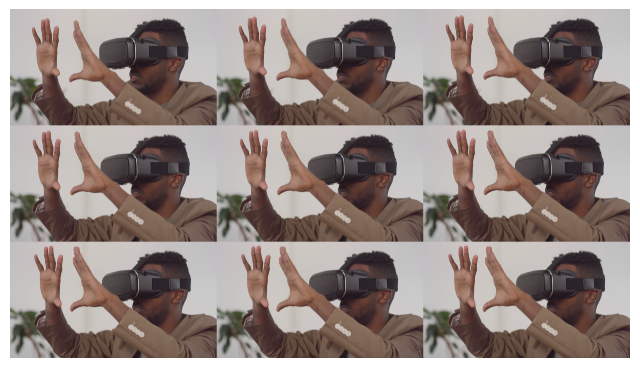

In [8]:
from PIL import Image

# Create a 3x3 collage of the first 9 frames
collage_frames = frame_files[:9]
imgs = [Image.open(os.path.join(output_dir, f)) for f in collage_frames]

width, height = imgs[0].size
collage = Image.new('RGB', (3 * width, 3 * height))

for idx, img in enumerate(imgs):
    x = (idx % 3) * width
    y = (idx // 3) * height
    collage.paste(img, (x, y))

collage.save("video_collage.png")
collage.show()

import matplotlib.pyplot as plt
import cv2

# Read and convert the collage image for display
collage_img = cv2.imread("video_collage.png")
collage_rgb = cv2.cvtColor(collage_img, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(collage_rgb)
plt.axis('off')
plt.show()


In [34]:
from google.colab import files
files.upload()  # Upload kaggle.json file

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shiva1230","key":"0abae99175601656c4bbc37361a1d62a"}'}

In [35]:
import os
import zipfile

# Set up Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"  # Set environment variable for kaggle.json

# Unzip the Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Install Kaggle API
!pip install kaggle


In [36]:
!chmod 600 /root/.kaggle/kaggle.json


In [2]:
import zipfile

with zipfile.ZipFile(r"C:\Users\shukl\Probability Project\Lab10\archive (5).zip", 'r') as zip_ref:
    zip_ref.extractall(r"C:\Users\shukl\Probability Project\Lab10")


In [4]:
import os

# Correct path where you extracted your videos
root_path = r"C:\Users\shukl\Probability Project\Lab10\UCF101\UCF-101"


# List all files and folders
for root, dirs, files in os.walk(root_path):
    print("Current directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)
    print("-" * 50)


Current directory: C:\Users\shukl\Probability Project\Lab10\UCF101\UCF-101
Subdirectories: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'Hammering', 'HammerThrow', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'Playin

In [5]:
import os
import shutil
import random

# NO extra space now + corrected to UCF-101
SOURCE_DIR = r'C:\Users\shukl\Probability Project\Lab10\UCF101\UCF-101'
DEST_DIR = r'C:\Users\shukl\Probability Project\Lab10\UCF_SUBSET'
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    selected = random.sample(os.listdir(class_path), VIDEOS_PER_CLASS)

    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print(f"Subset created at: {DEST_DIR}")


Subset created at: C:\Users\shukl\Probability Project\Lab10\UCF_SUBSET


In [16]:
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

IMG_SIZE = 112  # Resize to 112x112
SEQ_LEN = 16    # 16 frames per video
FRAME_INTERVAL = 5  # Take every 5th frame

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % FRAME_INTERVAL == 0:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frames.append(frame)
        count += 1
    cap.release()
    return np.array(frames[:SEQ_LEN]) if len(frames) >= SEQ_LEN else None

# Load and process videos
X, y = [], []
for cls in SELECTED_CLASSES:
    folder = os.path.join(DEST_DIR, cls)
    for video in os.listdir(folder):
        path = os.path.join(folder, video)
        frames = extract_frames(path)
        if frames is not None and frames.shape[0] == SEQ_LEN:
            X.append(frames)
            y.append(cls)

X = np.array(X)

# Label encode class names
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = to_categorical(y_encoded)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Training set size: (40, 16, 112, 112, 3), Test set size: (10, 16, 112, 112, 3)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(SEQ_LEN, IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling3D(pool_size=(1, 2, 2)),
    BatchNormalization(),
    Conv3D(64, (3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(SELECTED_CLASSES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 110, 110, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 55, 55, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 55, 55, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 53, 53, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 26, 26, 64)    0         
 3D)                                                             
                                                        

In [18]:
history = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_split=0.1)


Epoch 1/10
18/18 [==============================] - 25s 1s/step - loss: 67.0008 - accuracy: 0.2500 - val_loss: 676.5901 - val_accuracy: 0.2500
Epoch 2/10
18/18 [==============================] - 24s 1s/step - loss: 50.4033 - accuracy: 0.6667 - val_loss: 317.0452 - val_accuracy: 0.2500
Epoch 3/10
18/18 [==============================] - 24s 1s/step - loss: 35.1089 - accuracy: 0.6944 - val_loss: 558.0966 - val_accuracy: 0.5000
Epoch 4/10
18/18 [==============================] - 24s 1s/step - loss: 26.9172 - accuracy: 0.7778 - val_loss: 331.3684 - val_accuracy: 0.2500
Epoch 5/10
18/18 [==============================] - 24s 1s/step - loss: 52.7845 - accuracy: 0.7778 - val_loss: 676.5191 - val_accuracy: 0.2500
Epoch 6/10
18/18 [==============================] - 24s 1s/step - loss: 12.3250 - accuracy: 0.9167 - val_loss: 1080.7079 - val_accuracy: 0.2500
Epoch 7/10
18/18 [==============================] - 24s 1s/step - loss: 18.0287 - accuracy: 0.9167 - val_loss: 1669.5687 - val_accuracy: 0.25

1/1 [==============================] - 1s 760ms/step
               precision    recall  f1-score   support

   Basketball       0.00      0.00      0.00         2
       Biking       0.00      0.00      0.00         2
     JumpRope       0.17      0.50      0.25         2
PlayingGuitar       0.00      0.00      0.00         2
       Typing       0.00      0.00      0.00         2

     accuracy                           0.10        10
    macro avg       0.03      0.10      0.05        10
 weighted avg       0.03      0.10      0.05        10



c:\Users\shukl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shukl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\shukl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

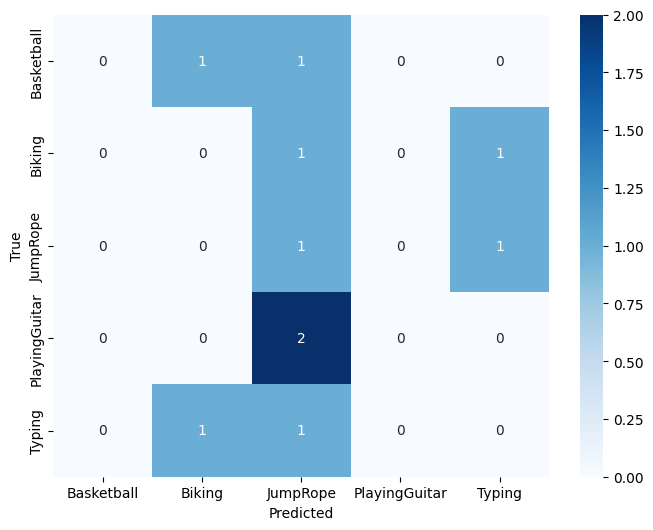

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=le.classes_)
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


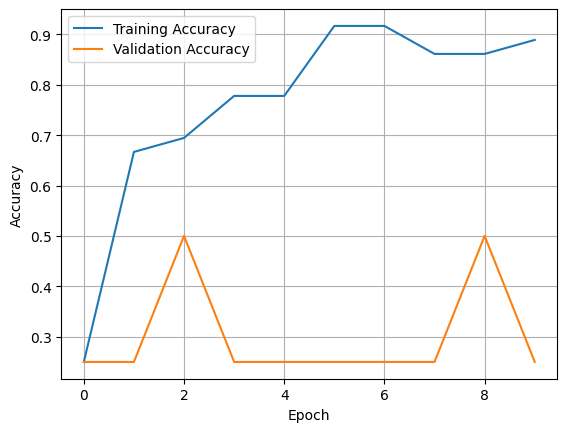

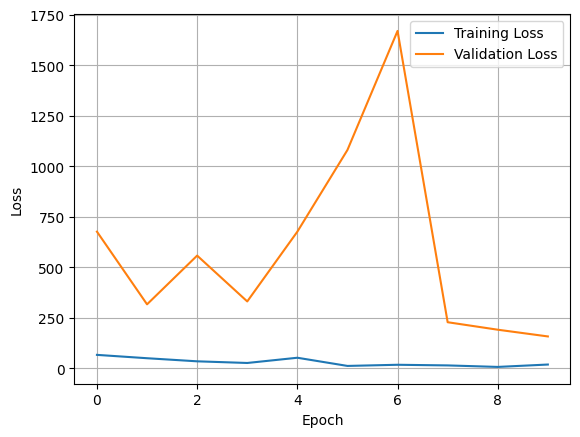

In [21]:
# Accuracy plot
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model.save(r'C:\Users\shukl\Probability Project\Lab10\model\m1.h5')
print("Model saved.")


Model saved.
